The aim of this homework is to practically test and analyze some of the machine learning algorithms studied during the course.

In [1]:
# INITIALIZATION

# MAIN IMPORT
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn import metrics
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import neighbors
from sklearn import svm
from operator import itemgetter
from sklearn.model_selection import KFold
# IMPORT DATASET FIRST 2 COLUMN
dataset, label = load_wine(return_X_y = True)
dataset2c = dataset[:, :2]
# SPLIT INTO TRAIN-VALIDATION-TEST 5-2-3
x_train, x_test, y_train, y_test = train_test_split(dataset2c, label, test_size=0.5, stratify=label, random_state=15)
x_validation, x_test, y_validation, y_test = train_test_split(x_test, y_test, test_size=0.6, stratify=y_test, random_state=15)
# NORMALIZE DATASET
scaler = StandardScaler()
scaler.fit(np.concatenate([x_train,x_validation]))
x_train = scaler.transform(x_train)
x_validation = scaler.transform(x_validation)
x_test = scaler.transform(x_test)
# VARIABLES
color_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
color_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
arange_step = 0.01
k_values = [1,3,5,7]
c_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
gamma_values = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 100, 1000]

The data used are futures (two attributes) and labels (that represents three classes) of a wine dataset from scikit learn library. All the following algorithms are `supervised learning models` developed to deal with `classification of multiple classes`: starting from his features the aim is to classify each sample into a class. Samples are split into **train** (50%), that the algorithm will use to build his model, **validation** (20%), that will be used to test the performance and to select the optimal parameters for the model, and **test** (30%), that will be used as effective verification of precision on the model with best parameters trained with both train and validation set. The split is made in such a way that labels have the same distribution in each subset in order to avoid particular cases that would lead to incorrect results. All futures are normalized with a scaler trained with the train and the validation set. Graphs that will be shown represent, through colored background, the spatial classification in the different classes obtained by the algorithm and, through colored points, the train samples (constants). As measure of success the **accuracy score** represents the percentage (from 0 up to 1) of classifications of the validation and test samples successfully made. 

# K-Nearest Neighbors classifier #

The `KNN classifier` assigns a class to a new sample watching the **most recurrent class of the K nearest samples**. The algorithm is iterated for K values {1, 3, 5, 7}.

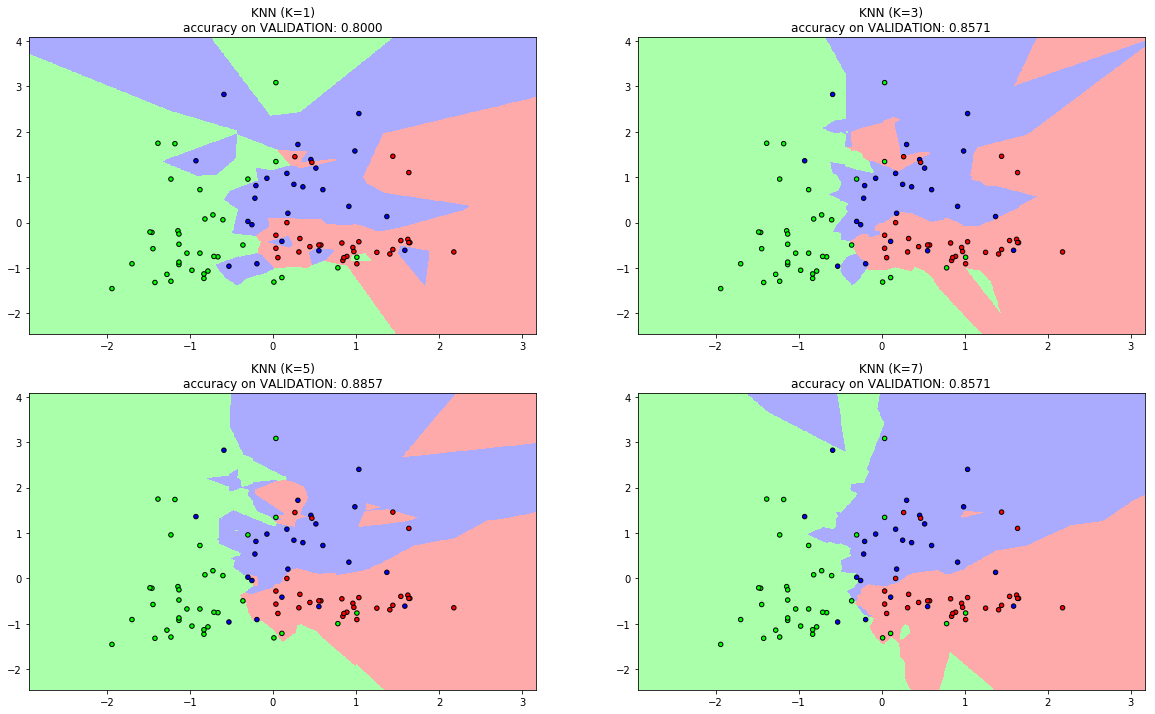

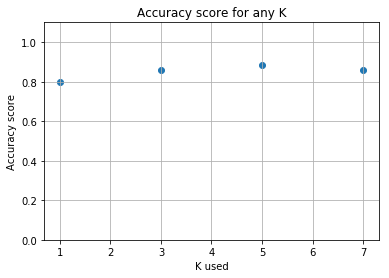

Best accuracy on VALIDATION: 0.8857
Best K: 5

Best KNN on TEST (K=5): accuracy: 0.8704


In [2]:
# KNN

accuracy = []
fig, sub = plt.subplots(2, 2)
fig.set_size_inches(10*2, 6*2)
# CYCLING K=[1,3,5,7]
for cycle_k, graph in zip(k_values, sub.flatten()):
    # CREATE AND TRAIN KNN NEIGHBORS 
    knn = neighbors.KNeighborsClassifier(cycle_k)
    knn.fit(x_train, y_train)
    # MAKE PREDICTION ON VALIDATION
    prediction = knn.predict(x_validation)
    # CALCULATE ACCURACY
    k_score = metrics.accuracy_score(y_validation, prediction)
    accuracy.append(k_score)
    # PLOT DECISION BOUNDARY AND TRAIN POINTS
    x_min, x_max = x_train[:, 0].min() - 1, x_train[:, 0].max() + 1
    y_min, y_max = x_train[:, 1].min() - 1, x_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, arange_step), np.arange(y_min, y_max, arange_step))
    Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    graph.pcolormesh(xx, yy, Z, cmap=color_light)
    graph.scatter(x_train[:, 0], x_train[:, 1], c=y_train, cmap=color_bold, edgecolor='k', s=20)
    graph.set_xlim(xx.min(), xx.max())
    graph.set_ylim(yy.min(), yy.max())
    graph.set_title("KNN (K={})\naccuracy on VALIDATION: {:.4f}".format(cycle_k,k_score))
plt.show()
# PLOT K-ACCURACY GRAPH
kacc = plt
kacc.scatter(k_values, accuracy)
kacc.xlabel('K used')
kacc.ylabel('Accuracy score')
kacc.title('Accuracy score for any K')
kacc.grid()
kacc.ylim(0, 1.1)
kacc.show()
# SELECT BEST K
best_accuracy = np.max(accuracy)
print("Best accuracy on VALIDATION: {:.4f}".format(best_accuracy))
best_k = k_values[accuracy.index(best_accuracy)]
print("Best K: {}".format(best_k))
# RE-TRAIN BEST KNN
knn = neighbors.KNeighborsClassifier(best_k)
knn.fit(np.concatenate([x_train,x_validation]), np.concatenate([y_train,y_validation]))
# MAKE PREDICTION ON TEST
prediction = knn.predict(x_test)
# CALCULATE ACCURACY
final_score = metrics.accuracy_score(y_test, prediction)
print("\nBest KNN on TEST (K={}): accuracy: {:.4f}".format(best_k,final_score))

For K values 1 and 3 It is clear that classification areas are more jagged because isolated samples are considered relevant, higer K give more homogeneous separations. Accuracy scores on the validation set are likewise higher than 80%, the best K is 7 and It produces an accuracy score much higher than 80% also on the test set. Although the algorithm is quite onerous for the amount of distances computed, it seems to have excellent performance in classify this dataset.

# Support-Vector Machine classifier with Linear Kernel #

A `SVM classifier` builds a model that separates the space into regions of classification trying to **maximize the distance between samples and the border which separates regions of different classes**. 

Using a `linear kernel` the **distances are calculated as scalar product** <x, x'> between two samples, consequently the separation between different regions is composed by straight lines. The parameter C represents the measure of avoid misclassification for each training sample: using small C the SVM will separate regions with larger margin but will also misclassify more train samples, on the other hand a large value of C will successfully classify more train samples but the margin will be smaller. The algorithm is iterated for values of C in a range from 0.001 to 1000 in order to select the best one. 

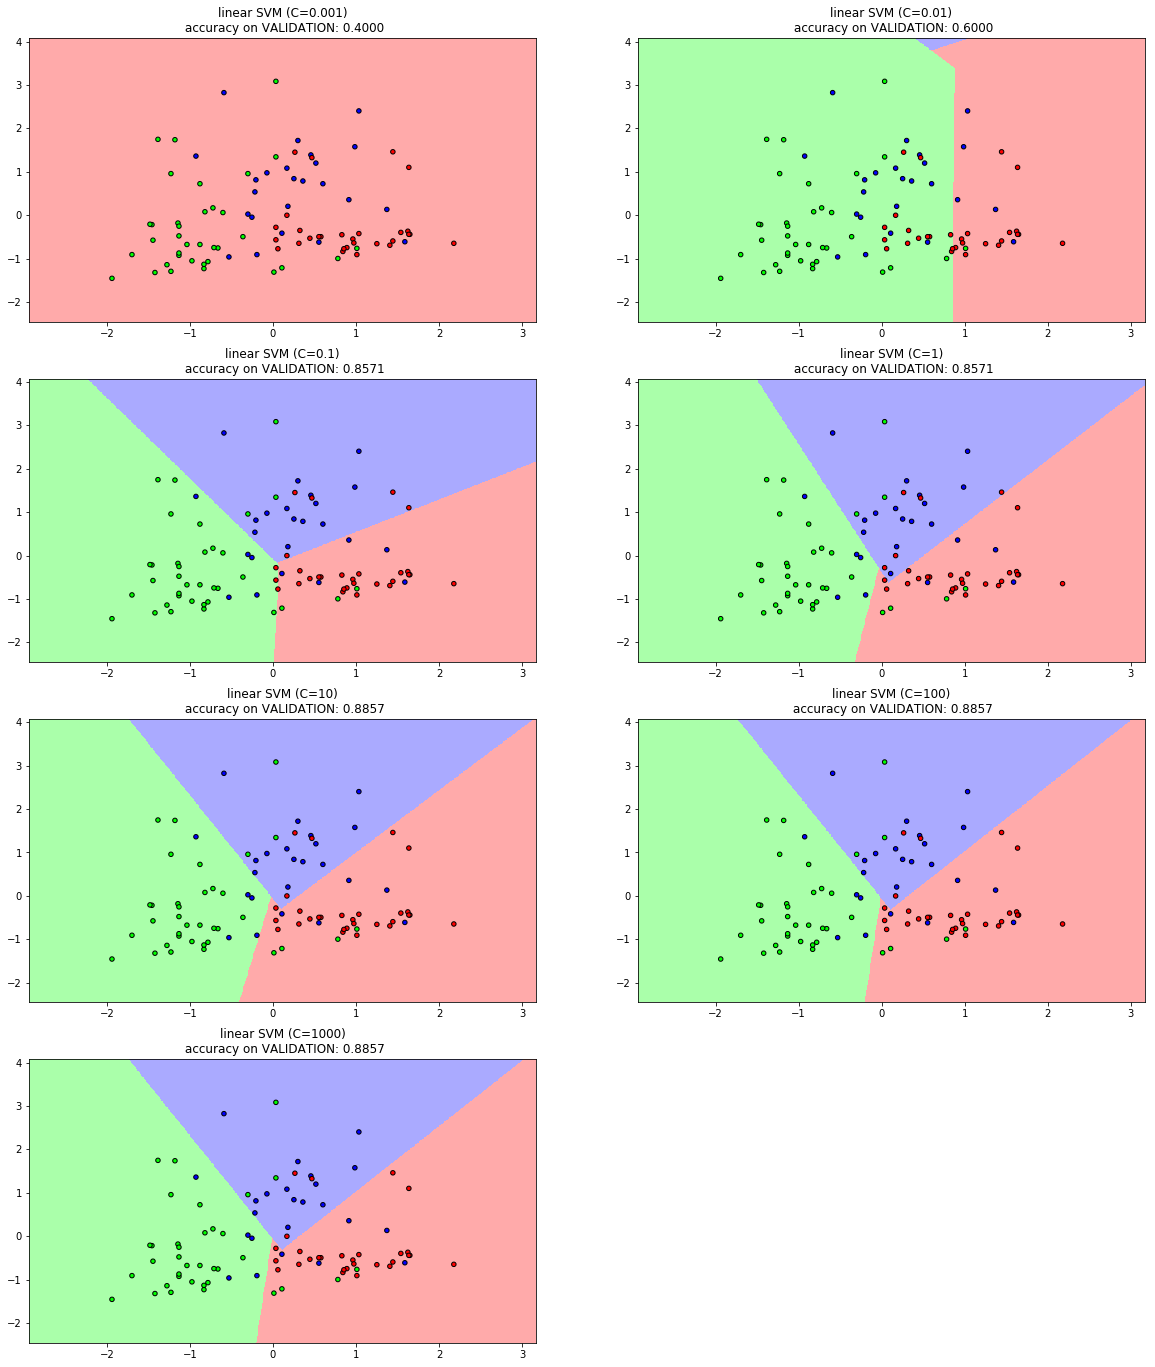

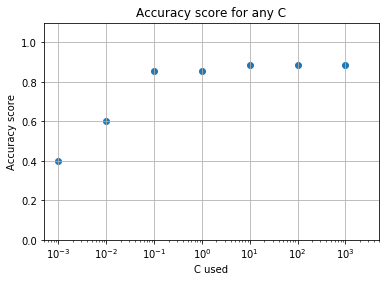

Best accuracy on VALIDATION: 0.8857
Best C: 10

Best linear SVM on TEST (C=10): accuracy: 0.7593


In [3]:
# SVM linear kernel

accuracy = []
fig, sub = plt.subplots(4, 2)
fig.set_size_inches(10*2, 6*4)
# CYCLING C=[0.001, 0.01, 0.1, 1, 10, 100, 1000]
for cycle_c, graph in zip(c_values, sub.flatten()):
    # CREATE AND TRAIN LINEAR SVM 
    linSVM = svm.SVC(C = cycle_c, kernel = 'linear')
    linSVM.fit(x_train, y_train)
    # MAKE PREDICTION ON VALIDATION
    prediction = linSVM.predict(x_validation)
    # CALCULATE ACCURACY
    c_score = metrics.accuracy_score(y_validation, prediction)
    accuracy.append(c_score)
    # PLOT DECISION BOUNDARY
    x_min, x_max = x_train[:, 0].min() - 1, x_train[:, 0].max() + 1
    y_min, y_max = x_train[:, 1].min() - 1, x_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, arange_step), np.arange(y_min, y_max, arange_step))
    Z = linSVM.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    graph.pcolormesh(xx, yy, Z, cmap=color_light)
    # OVERPLOT TRAIN POINTS
    graph.scatter(x_train[:, 0], x_train[:, 1], c=y_train, cmap=color_bold, edgecolor='k', s=20)
    graph.set_xlim(xx.min(), xx.max())
    graph.set_ylim(yy.min(), yy.max())
    graph.set_title("linear SVM (C={})\n accuracy on VALIDATION: {:.4f}".format(cycle_c,c_score))
sub[3,1].set_visible(False)
plt.show()
# PLOT C-ACCURACY GRAPH
cacc = plt
cacc.scatter(c_values, accuracy)
cacc.xlabel('C used')
cacc.ylabel('Accuracy score')
cacc.title('Accuracy score for any C')
cacc.grid()
cacc.ylim(0, 1.1)
cacc.xlim(0.0005, 5000)
cacc.xscale('log')
cacc.show()
# SELECT BEST C
best_accuracy = np.max(accuracy)
print("Best accuracy on VALIDATION: {:.4f}".format(best_accuracy))
best_c = c_values[accuracy.index(best_accuracy)]
print("Best C: {}".format(best_c))
# RE-TRAIN BEST LINEAR SVM
linSVM = svm.SVC(C = best_c, kernel = 'linear')
linSVM.fit(np.concatenate([x_train,x_validation]), np.concatenate([y_train,y_validation]))
# MAKE PREDICTION ON TEST
prediction = linSVM.predict(x_test)
# CALCULATE ACCURACY
final_score = metrics.accuracy_score(y_test, prediction)
print("\nBest linear SVM on TEST (C={}): accuracy: {:.4f}".format(best_c,final_score))

As the first graph shows, tiniest value of C (0.001 and also 0.01) cause the algorithm to diverge classifying the entire space as an unique class or as only two. This happens probably because the dataset is not enought big so that a small C allows to misclassify a huge portion of train samples. Values of C from 0.1 to 1000 produce an accuracy score on the validation set above 80%. In case of having the same score it is better to choose the smaller C in order to reduce misclassification. The best C (10) gives an accuracy on the test set of 75%. The discrepancy of more than 10% between the train-validation and the test accuracy denotes that linear separation doesn't fit excellently with this data.

# Support-Vector Machine classifier with Radial Basis Function Kernel #

Using a SVM with a `RBF kernel` the **distances are calculated with the Gaussian formula** e^(-gamma*||x - x'||^2) . In this first case the value of  gamma  is by default chosen automatically.

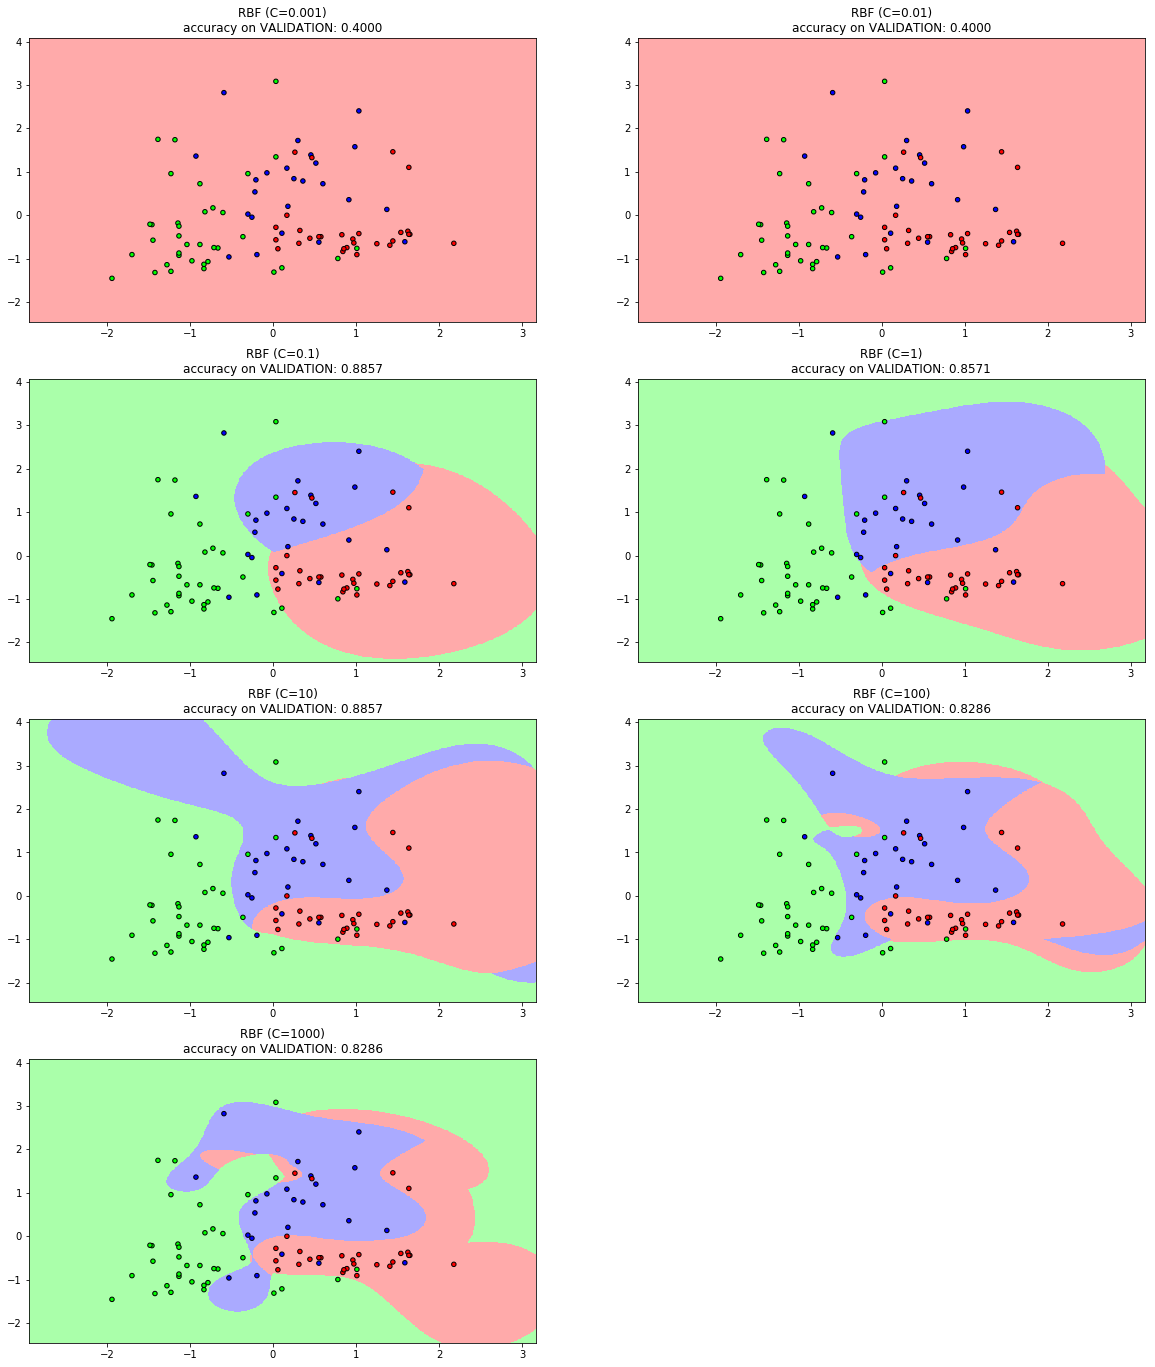

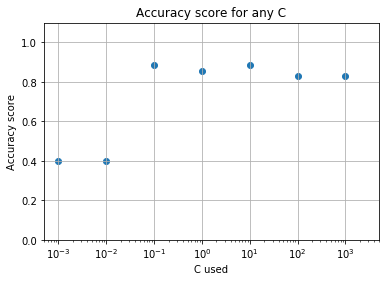

Best accuracy on VALIDATION: 0.8857
Best C: 0.1

Best RBF on TEST (C=0.1): accuracy: 0.7593


In [4]:
# SVM RBF kernel

accuracy = []
fig, sub = plt.subplots(4, 2)
fig.set_size_inches(10*2, 6*4)
# CYCLING C=[0.001, 0.01, 0.1, 1, 10, 100, 1000]
for cycle_c, graph in zip(c_values, sub.flatten()):
    # CREATE AND TRAIN RBF 
    RBF = svm.SVC(C = cycle_c, kernel = 'rbf', gamma = 'auto')
    RBF.fit(x_train, y_train)
    # MAKE PREDICTION ON VALIDATION
    prediction = RBF.predict(x_validation)
    # CALCULATE ACCURACY
    c_score = metrics.accuracy_score(y_validation, prediction)
    accuracy.append(c_score)
    # PLOT DECISION BOUNDARY
    x_min, x_max = x_train[:, 0].min() - 1, x_train[:, 0].max() + 1
    y_min, y_max = x_train[:, 1].min() - 1, x_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, arange_step), np.arange(y_min, y_max, arange_step))
    Z = RBF.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    graph.pcolormesh(xx, yy, Z, cmap=color_light)
    # OVERPLOT TRAIN POINTS
    graph.scatter(x_train[:, 0], x_train[:, 1], c=y_train, cmap=color_bold, edgecolor='k', s=20)
    graph.set_xlim(xx.min(), xx.max())
    graph.set_ylim(yy.min(), yy.max())
    graph.set_title("RBF (C={})\naccuracy on VALIDATION: {:.4f}".format(cycle_c,c_score))
sub[3,1].set_visible(False)
plt.show()
# PLOT C-ACCURACY GRAPH
rbfacc = plt
rbfacc.scatter(c_values, accuracy)
rbfacc.xlabel('C used')
rbfacc.ylabel('Accuracy score')
rbfacc.title('Accuracy score for any C')
rbfacc.grid()
rbfacc.ylim(0, 1.1)
rbfacc.xlim(0.0005, 5000)
rbfacc.xscale('log')
rbfacc.show()
# SELECT BEST C
best_accuracy = np.max(accuracy)
print("Best accuracy on VALIDATION: {:.4f}".format(best_accuracy))
best_c = c_values[accuracy.index(best_accuracy)]
print("Best C: {}".format(best_c))
# RE-TRAIN BEST RBF
RBF = svm.SVC(C = best_c, kernel = 'rbf', gamma = 'auto')
RBF.fit(np.concatenate([x_train,x_validation]), np.concatenate([y_train,y_validation]))
# MAKE PREDICTION ON TEST
prediction = RBF.predict(x_test)
# CALCULATE ACCURACY
final_score = metrics.accuracy_score(y_test, prediction)
print("\nBest RBF on TEST (C={}): accuracy: {:.4f}".format(best_c,final_score))

C values are iterated, It appears again that smaller values (up to 0.1) cause the model to degenerate classifying all the space into only one class for the same reasons. Also in this case higher values of C lead to accuracy scores above 80%, the accuracy score of the model applied to the test set with the best C (0.1) is quite less than the expected (~75%). Despite boundaries are clearly different because not linear, accuracy scores on this data seems to be similar as linear kernel SVM.

## SVM classifier with RBF Kernel cycling gamma ##

Now the parameter gamma, weight in the RBF exponential calculus of the distance between two samples, is varied in a range from 0.00001 to 1000 together with the C in order to find the better combination of the two parameters. In particular, if gamma is too big each sample influences only himself and the model will be **overfitted** (It will strongly represent the training set but It will not be general enough to fit with new samples), on the other hand if gamma is too small every sample will influence all the other samples including the most distant. 

RBF on VALIDATION (C=0.001, gamma=1e-05): accuracy score: 0.4000
RBF on VALIDATION (C=0.001, gamma=0.0001): accuracy score: 0.4000
RBF on VALIDATION (C=0.001, gamma=0.001): accuracy score: 0.4000
RBF on VALIDATION (C=0.001, gamma=0.01): accuracy score: 0.4000
RBF on VALIDATION (C=0.001, gamma=0.1): accuracy score: 0.4000
RBF on VALIDATION (C=0.001, gamma=1): accuracy score: 0.4000
RBF on VALIDATION (C=0.001, gamma=100): accuracy score: 0.4000
RBF on VALIDATION (C=0.001, gamma=1000): accuracy score: 0.4000
RBF on VALIDATION (C=0.01, gamma=1e-05): accuracy score: 0.4000
RBF on VALIDATION (C=0.01, gamma=0.0001): accuracy score: 0.4000
RBF on VALIDATION (C=0.01, gamma=0.001): accuracy score: 0.4000
RBF on VALIDATION (C=0.01, gamma=0.01): accuracy score: 0.4000
RBF on VALIDATION (C=0.01, gamma=0.1): accuracy score: 0.4000
RBF on VALIDATION (C=0.01, gamma=1): accuracy score: 0.4000
RBF on VALIDATION (C=0.01, gamma=100): accuracy score: 0.4000
RBF on VALIDATION (C=0.01, gamma=1000): accuracy 

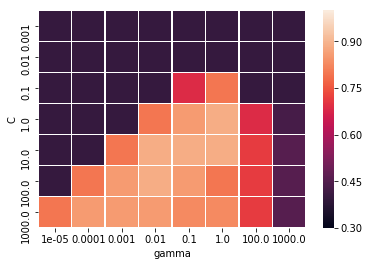

Best accuracy on VALIDATION: 0.8857
Best C: 1
Best gamma: 1


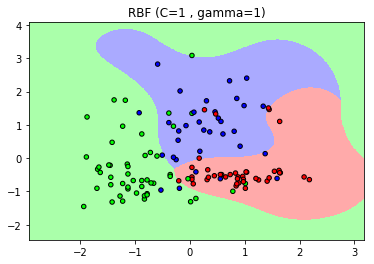


Best RBF on TEST (C=1, gamma=1): accuracy: 0.8333


In [5]:
# SVM RBF cycling gamma

scores = []
accuracy = []
# CYCLING C AND GAMMA=[1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 100, 1000]
for cycle_c in c_values:
    for cycle_gamma in gamma_values:
        # CREATE AND TRAIN RBF 
        RBF = svm.SVC(C = cycle_c, kernel = 'rbf', gamma = cycle_gamma)
        RBF.fit(x_train, y_train)
        # MAKE PREDICTION ON VALIDATION
        prediction = RBF.predict(x_validation)
        # CALCULATE ACCURACY
        c_gamma_score = metrics.accuracy_score(y_validation, prediction)
        scores.append(tuple((c_gamma_score, cycle_c, cycle_gamma)))
        accuracy.append(c_gamma_score)
        print("RBF on VALIDATION (C={}, gamma={}): accuracy score: {:.4f}".format(cycle_c, cycle_gamma, c_gamma_score))
# HEATMAP C-GAMMA-SCORE
matrixHeatmap = np.asarray(scores)
matrixHeatmap = matrixHeatmap[:,[1, 2, 0]]
matrixHeatmap = pd.DataFrame(matrixHeatmap, columns=['C', 'gamma', 'accuracy'])
matrixHeatmap = matrixHeatmap.pivot("C", "gamma", "accuracy")
ax = sns.heatmap(matrixHeatmap, vmin=0.3, vmax=1, linewidths=.5)
plt.show()
# SELECT BEST C AND GAMMA
best_accuracy, best_c, best_gamma = max(scores,key=itemgetter(0))
print("Best accuracy on VALIDATION: {:.4f}".format(best_accuracy))
print("Best C: {}".format(best_c))
print("Best gamma: {}".format(best_gamma))
# RE-TRAIN BEST RBF
RBF = svm.SVC(C = best_c, kernel = 'rbf', gamma = best_gamma)
RBF.fit(np.concatenate([x_train,x_validation]), np.concatenate([y_train,y_validation]))
# PLOT BEST DECISION BOUNDARY AND TRAIN POINTS
x_min, x_max = x_train[:, 0].min() - 1, x_train[:, 0].max() + 1
y_min, y_max = x_train[:, 1].min() - 1, x_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, arange_step), np.arange(y_min, y_max, arange_step))
Z = RBF.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=color_light)
plt.scatter(np.concatenate([x_train[:, 0], x_validation[:, 0]]), 
            np.concatenate([x_train[:, 1], x_validation[:, 1]]), c=np.concatenate([y_train, y_validation]), 
            cmap=color_bold, edgecolor='k', s=20)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("RBF (C={} , gamma={})".format(best_c, best_gamma))
plt.show()
# MAKE PREDICTION ON TEST
prediction = RBF.predict(x_test)
# CALCULATE ACCURACY
final_score = metrics.accuracy_score(y_test, prediction)
print("\nBest RBF on TEST (C={}, gamma={}): accuracy: {:.4f}".format(best_c, best_gamma, final_score))

The heatmap represents the accuracy scores optained varying C and gamma, lighter cells shows better scores. The best combination (C=1 and gamma=1) gives an accuracy score slightly lower 90%, the model applied to the test set exceeds 80%. It is evident that cycling both the parameters lead to a better result instead of using the default parameters.

## SVM classifier with RBF Kernel cycling gamma with K-Fold Validation ##

Train set and validation set are now merged to apply a 5-fold validation. The **K-fold validation** is an iteration procedure in which all the data, except the test ones, are randomly splitted K times into train and validation in different ways in order to perform the procedure avoiding special cases of samples distribution.

RBF on VALIDATION (split 0, C=0.001, gamma=1e-05): accuracy score: 0.3889
RBF on VALIDATION (split 0, C=0.001, gamma=0.0001): accuracy score: 0.3889
RBF on VALIDATION (split 0, C=0.001, gamma=0.001): accuracy score: 0.3889
RBF on VALIDATION (split 0, C=0.001, gamma=0.01): accuracy score: 0.3889
RBF on VALIDATION (split 0, C=0.001, gamma=0.1): accuracy score: 0.3889
RBF on VALIDATION (split 0, C=0.001, gamma=1): accuracy score: 0.3889
RBF on VALIDATION (split 0, C=0.001, gamma=100): accuracy score: 0.3889
RBF on VALIDATION (split 0, C=0.001, gamma=1000): accuracy score: 0.3889
RBF on VALIDATION (split 0, C=0.01, gamma=1e-05): accuracy score: 0.3889
RBF on VALIDATION (split 0, C=0.01, gamma=0.0001): accuracy score: 0.3889
RBF on VALIDATION (split 0, C=0.01, gamma=0.001): accuracy score: 0.3889
RBF on VALIDATION (split 0, C=0.01, gamma=0.01): accuracy score: 0.3889
RBF on VALIDATION (split 0, C=0.01, gamma=0.1): accuracy score: 0.3889
RBF on VALIDATION (split 0, C=0.01, gamma=1): accuracy

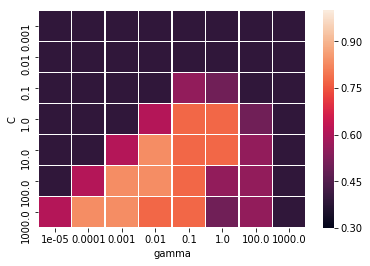

RBF on VALIDATION (split 1, C=0.001, gamma=1e-05): accuracy score: 0.3889
RBF on VALIDATION (split 1, C=0.001, gamma=0.0001): accuracy score: 0.3889
RBF on VALIDATION (split 1, C=0.001, gamma=0.001): accuracy score: 0.3889
RBF on VALIDATION (split 1, C=0.001, gamma=0.01): accuracy score: 0.3889
RBF on VALIDATION (split 1, C=0.001, gamma=0.1): accuracy score: 0.3889
RBF on VALIDATION (split 1, C=0.001, gamma=1): accuracy score: 0.3889
RBF on VALIDATION (split 1, C=0.001, gamma=100): accuracy score: 0.3889
RBF on VALIDATION (split 1, C=0.001, gamma=1000): accuracy score: 0.3889
RBF on VALIDATION (split 1, C=0.01, gamma=1e-05): accuracy score: 0.3889
RBF on VALIDATION (split 1, C=0.01, gamma=0.0001): accuracy score: 0.3889
RBF on VALIDATION (split 1, C=0.01, gamma=0.001): accuracy score: 0.3889
RBF on VALIDATION (split 1, C=0.01, gamma=0.01): accuracy score: 0.3889
RBF on VALIDATION (split 1, C=0.01, gamma=0.1): accuracy score: 0.3889
RBF on VALIDATION (split 1, C=0.01, gamma=1): accuracy

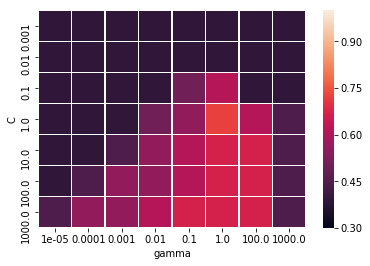

RBF on VALIDATION (split 2, C=0.001, gamma=1e-05): accuracy score: 0.4444
RBF on VALIDATION (split 2, C=0.001, gamma=0.0001): accuracy score: 0.4444
RBF on VALIDATION (split 2, C=0.001, gamma=0.001): accuracy score: 0.4444
RBF on VALIDATION (split 2, C=0.001, gamma=0.01): accuracy score: 0.4444
RBF on VALIDATION (split 2, C=0.001, gamma=0.1): accuracy score: 0.4444
RBF on VALIDATION (split 2, C=0.001, gamma=1): accuracy score: 0.4444
RBF on VALIDATION (split 2, C=0.001, gamma=100): accuracy score: 0.4444
RBF on VALIDATION (split 2, C=0.001, gamma=1000): accuracy score: 0.4444
RBF on VALIDATION (split 2, C=0.01, gamma=1e-05): accuracy score: 0.4444
RBF on VALIDATION (split 2, C=0.01, gamma=0.0001): accuracy score: 0.4444
RBF on VALIDATION (split 2, C=0.01, gamma=0.001): accuracy score: 0.4444
RBF on VALIDATION (split 2, C=0.01, gamma=0.01): accuracy score: 0.4444
RBF on VALIDATION (split 2, C=0.01, gamma=0.1): accuracy score: 0.4444
RBF on VALIDATION (split 2, C=0.01, gamma=1): accuracy

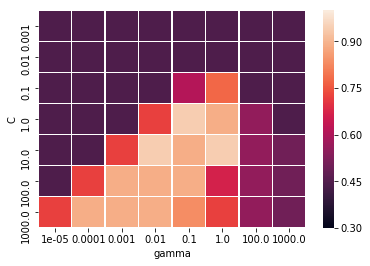

RBF on VALIDATION (split 3, C=0.001, gamma=1e-05): accuracy score: 0.5000
RBF on VALIDATION (split 3, C=0.001, gamma=0.0001): accuracy score: 0.5000
RBF on VALIDATION (split 3, C=0.001, gamma=0.001): accuracy score: 0.5000
RBF on VALIDATION (split 3, C=0.001, gamma=0.01): accuracy score: 0.5000
RBF on VALIDATION (split 3, C=0.001, gamma=0.1): accuracy score: 0.5000
RBF on VALIDATION (split 3, C=0.001, gamma=1): accuracy score: 0.5000
RBF on VALIDATION (split 3, C=0.001, gamma=100): accuracy score: 0.5000
RBF on VALIDATION (split 3, C=0.001, gamma=1000): accuracy score: 0.5000
RBF on VALIDATION (split 3, C=0.01, gamma=1e-05): accuracy score: 0.5000
RBF on VALIDATION (split 3, C=0.01, gamma=0.0001): accuracy score: 0.5000
RBF on VALIDATION (split 3, C=0.01, gamma=0.001): accuracy score: 0.5000
RBF on VALIDATION (split 3, C=0.01, gamma=0.01): accuracy score: 0.5000
RBF on VALIDATION (split 3, C=0.01, gamma=0.1): accuracy score: 0.5000
RBF on VALIDATION (split 3, C=0.01, gamma=1): accuracy

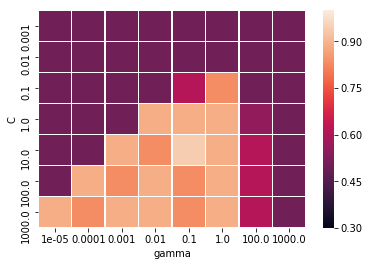

RBF on VALIDATION (split 4, C=0.001, gamma=1e-05): accuracy score: 0.2941
RBF on VALIDATION (split 4, C=0.001, gamma=0.0001): accuracy score: 0.2941
RBF on VALIDATION (split 4, C=0.001, gamma=0.001): accuracy score: 0.2941
RBF on VALIDATION (split 4, C=0.001, gamma=0.01): accuracy score: 0.2941
RBF on VALIDATION (split 4, C=0.001, gamma=0.1): accuracy score: 0.2941
RBF on VALIDATION (split 4, C=0.001, gamma=1): accuracy score: 0.2941
RBF on VALIDATION (split 4, C=0.001, gamma=100): accuracy score: 0.2941
RBF on VALIDATION (split 4, C=0.001, gamma=1000): accuracy score: 0.2941
RBF on VALIDATION (split 4, C=0.01, gamma=1e-05): accuracy score: 0.2941
RBF on VALIDATION (split 4, C=0.01, gamma=0.0001): accuracy score: 0.2941
RBF on VALIDATION (split 4, C=0.01, gamma=0.001): accuracy score: 0.2941
RBF on VALIDATION (split 4, C=0.01, gamma=0.01): accuracy score: 0.2941
RBF on VALIDATION (split 4, C=0.01, gamma=0.1): accuracy score: 0.2941
RBF on VALIDATION (split 4, C=0.01, gamma=1): accuracy

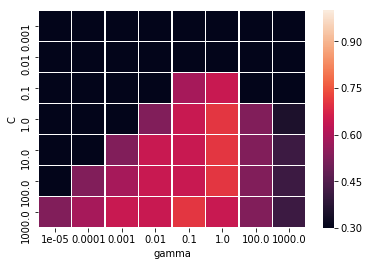

Best accuracy on VALIDATION: 0.9444 (split 2)
Best C: 1
Best gamma: 0.1


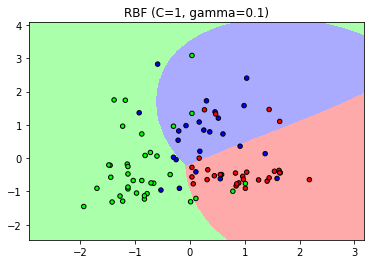


Best RBF on TEST (C=1, gamma=0.1): accuracy: 0.7963


In [6]:
# SVM RBF cycling gamma with 70/30 5-fold validation

scores = []
# MERGE TRAIN AND VALIDATION
np.append(x_train,x_validation)
np.append(y_train,y_validation)
# APPLY 5-FOLD TO GENERATE INDEXES
kf = KFold(n_splits = 5)
kfcount = 0
# CYCLING ON X TRAIN AND VALIDATION GENERATED
for x_train_kf, x_validation_kf in kf.split(x_train):
    scoresHeatmap = []
    # CYCLING C AND GAMMA
    for cycle_c in c_values:
        for cycle_gamma in gamma_values:
            # CREATE AND TRAIN RBF 
            RBF = svm.SVC(C = cycle_c, kernel = 'rbf', gamma = cycle_gamma)
            RBF.fit(x_train[x_train_kf], y_train[x_train_kf])
            # MAKE PREDICTION ON VALIDATION
            prediction = RBF.predict(x_train[x_validation_kf])
            # CALCULATE ACCURACY
            c_gamma_score = metrics.accuracy_score(y_train[x_validation_kf], prediction)
            scores.append(tuple((c_gamma_score, cycle_c, cycle_gamma,x_train_kf,x_validation_kf,kfcount)))
            scoresHeatmap.append(tuple((c_gamma_score, cycle_c, cycle_gamma)))
            print("RBF on VALIDATION (split {}, C={}, gamma={}): accuracy score: {:.4f}"
                  .format(kfcount, cycle_c, cycle_gamma, c_gamma_score))
    kfcount+=1
    # HEATMAP C-GAMMA-SCORE PER KFOLD
    matrixHeatmap = np.asarray(scoresHeatmap)
    matrixHeatmap = matrixHeatmap[:,[1, 2, 0]]
    matrixHeatmap = pd.DataFrame(matrixHeatmap, columns=['C', 'gamma', 'accuracy'])
    matrixHeatmap = matrixHeatmap.pivot("C", "gamma", "accuracy")
    ax = sns.heatmap(matrixHeatmap,vmin=0.3, vmax=1,linewidths=.5) 
    plt.show()
# SELECT BEST C AND GAMMA
best_accuracy, best_c, best_gamma, best_x_train_kf, best_x_validation_kf, best_kf = max(scores,key=itemgetter(0))
print("Best accuracy on VALIDATION: {:.4f} (split {})".format(best_accuracy, best_kf))
print("Best C: {}".format(best_c))
print("Best gamma: {}".format(best_gamma))
# RE-TRAIN BEST RBF
RBF = svm.SVC(C = best_c, kernel = 'rbf', gamma = best_gamma)
RBF.fit(x_train, y_train)
# PLOT BEST DECISION BOUNDARY AND TRAIN POINTS
x_min, x_max = x_train[:, 0].min() - 1, x_train[:, 0].max() + 1
y_min, y_max = x_train[:, 1].min() - 1, x_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, arange_step), np.arange(y_min, y_max, arange_step))
Z = RBF.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=color_light)
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train, cmap=color_bold, edgecolor='k', s=20)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("RBF (C={}, gamma={})".format(best_c, best_gamma))
plt.show()
# MAKE PREDICTION ON TEST
prediction = RBF.predict(x_test)
# CALCULATE ACCURACY
final_score = metrics.accuracy_score(y_test, prediction)
print("\nBest RBF on TEST (C={}, gamma={}): accuracy: {:.4f}".format(best_c, best_gamma, final_score))


The procedure of train and validation is performed cycling C and gamma for each of the 5 different splits, the heatmaps show that for each split the results are similar in reference to parameters but each time quite better or worse. The best C and gamma are selected, though the best accuracy score on one of the the validations is 94%, the model on test set scores less than 80%. This denotes that, in this case and with this dataset, K-fold did not bring to a better result.